In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import timeit
import statistics
import time
import torch
import torch_geometric
import importlib

from data_utils import synthetic_data
from data_utils import graph_constructors

import networkx as nx

import importlib

In [26]:
importlib.reload(synthetic_data)
importlib.reload(graph_constructors)

<module 'data_utils.graph_constructors' from 'C:\\Users\\andy.knapper\\Documents\\OW\\Categorisation\\ML grouping\\GNN-for-trans-grouping\\data_utils\\graph_constructors.py'>

In [ ]:
%timeit synthetic_data.make_a_group()

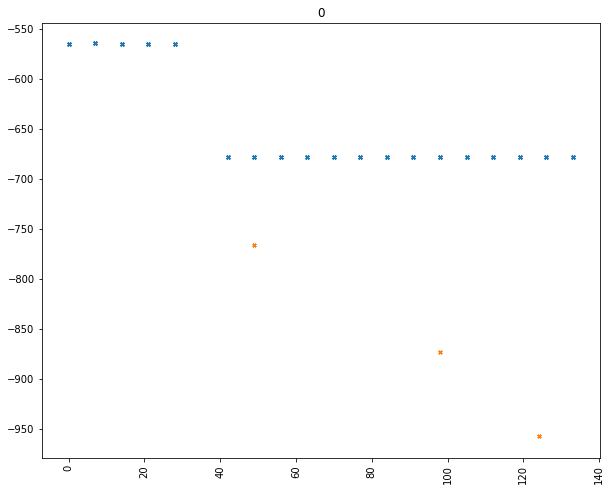

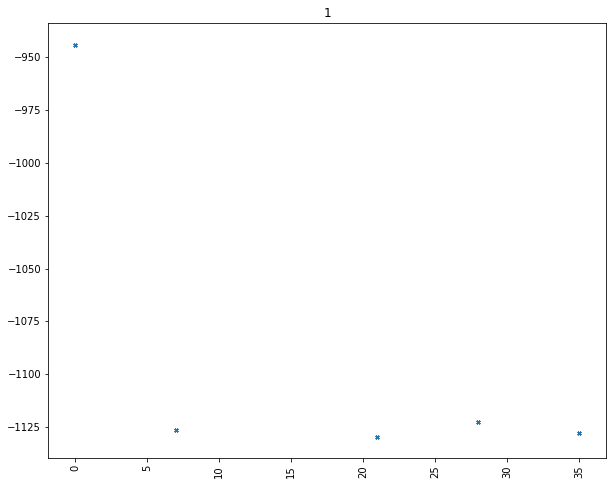

In [5]:
colour_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for i in range(2):
    d_lst, a_lst, g_lst, t_lst = synthetic_data.make_a_group()
    
    d_arr = np.array(d_lst)
    a_arr = np.array(a_lst)
    g_arr = np.array(g_lst)    
    
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10,8), sharex=True)
    for g in g_lst:
        mask = (g_arr == g)
        
        ax1.scatter(d_arr[mask], a_arr[mask], s=10, c=colour_list[g%10], marker='x')
        ax1.set_title(str(i))
        #ax1.legend(loc="upper right")
    
    for ax1 in fig.axes:
        matplotlib.pyplot.sca(ax1)
        plt.xticks(rotation=90)
        #plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    
    plt.show

In [37]:
d_lst, a_lst, g_lst, t_lst = synthetic_data.make_a_group()

In [38]:
d_arr = np.array(d_lst)
a_arr = np.array(a_lst)
g_arr = np.array(g_lst)
t_arr = np.array(t_lst)

In [40]:
norm_a_arr = graph_constructors.normalise_amounts(a_arr)

In [39]:
data = graph_constructors.make_pyg_graph_no_edge_attr(d_arr, a_arr, g_arr, t_arr)

In [42]:
data.x.shape

torch.Size([52, 14])

In [44]:
data.y.shape

torch.Size([52])

In [45]:
node_ids = [x for x in range(len(d_arr))]
positions_list = [(x[0], x[1]) for x in data['pos'].tolist()]
pos_dict = dict(zip(node_ids, positions_list))

In [46]:
g = torch_geometric.utils.to_networkx(data, node_attrs=None, edge_attrs=None)

C:\Users\andy.knapper\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\andy.knapper\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


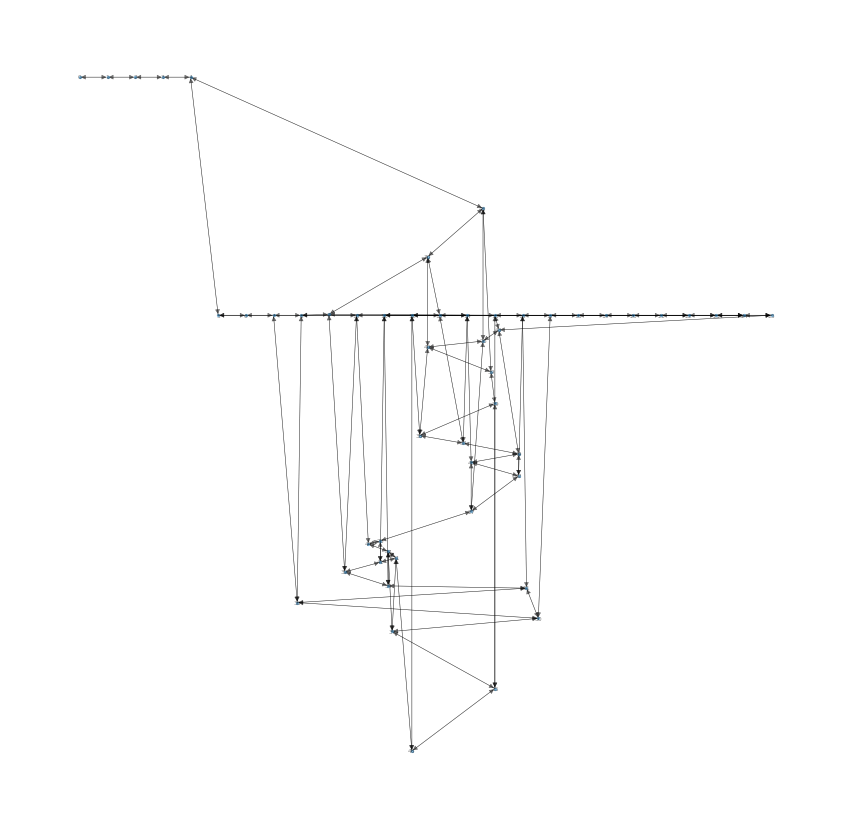

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
nx.draw_networkx(g, ax=ax, node_size=5,
                 font_size=6, alpha=.5,
                 width=.5, pos = pos_dict)
ax.set_axis_off()

### Try a simple model first

In [157]:
# #from torch.utils.data import Dataset, DataLoader
# from torch_geometric.data import Data, DataLoader
# from torchvision import transforms, datasets, models

# class SimDataset(Dataset):
#     def __init__(self, count):
#         self.sim_data = [graph_constructors.make_pyg_graph_no_edge_attr(*np.array(synthetic_data.make_a_group())) for _ in range(count)]
#         self.input_graphs = [(g.x, g.edge_index) for  g in self.sim_data]
#         self.targets = [g.y for g in self.sim_data]#.astype('float32')

#     def __len__(self):
#         return len(self.input_graphs)

#     def __getitem__(self, idx):
#         graph = self.input_graphs[idx]
#         target = self.targets[idx]
#         return [graph, target]


# train_set = SimDataset(2000)
# val_set = SimDataset(200)

# graph_datasets = {
#     'train': train_set, 'val': val_set
# }

# batch_size = 4

# dataloaders = {
#     'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
#     'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
# }

In [176]:
from torch_geometric.data import Data, DataLoader

train_data_list = [graph_constructors.make_pyg_graph_no_edge_attr(*np.array(synthetic_data.make_a_group())).to(device) for _ in range(2000)]
val_data_list = [graph_constructors.make_pyg_graph_no_edge_attr(*np.array(synthetic_data.make_a_group())).to(device) for _ in range(200)]

train_loader = DataLoader(train_data_list, batch_size=8)
val_loader = DataLoader(val_data_list, batch_size=8)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

In [53]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn import GINConv, global_add_pool

In [69]:
from torch_geometric.nn import GINConv, global_add_pool, models

In [105]:
import torch
import torch.nn.functional as F
from torch_sparse import spspmm
from torch_geometric.nn import TopKPooling, GCNConv
from torch_geometric.utils import (add_self_loops, sort_edge_index,
                                   remove_self_loops)
from torch_geometric.utils.repeat import repeat


class GraphUNet(torch.nn.Module):
    r"""The Graph U-Net model from the `"Graph U-Nets"
    <https://arxiv.org/abs/1905.05178>`_ paper which implements a U-Net like
    architecture with graph pooling and unpooling operations.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Size of each hidden sample.
        out_channels (int): Size of each output sample.
        depth (int): The depth of the U-Net architecture.
        pool_ratios (float or [float], optional): Graph pooling ratio for each
            depth. (default: :obj:`0.5`)
        sum_res (bool, optional): If set to :obj:`False`, will use
            concatenation for integration of skip connections instead
            summation. (default: :obj:`True`)
        act (torch.nn.functional, optional): The nonlinearity to use.
            (default: :obj:`torch.nn.functional.relu`)
    """

    def __init__(self, in_channels, hidden_channels, out_channels, depth,
                 pool_ratios=0.5, sum_res=True, act=F.relu):
        super(GraphUNet, self).__init__()
        assert depth >= 1
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.depth = depth
        self.pool_ratios = repeat(pool_ratios, depth)
        self.act = act
        self.sum_res = sum_res

        channels = hidden_channels

        self.down_convs = torch.nn.ModuleList()
        self.pools = torch.nn.ModuleList()
        self.down_convs.append(GCNConv(in_channels, channels, improved=True))
        for i in range(depth):
            self.pools.append(TopKPooling(channels, self.pool_ratios[i]))
            self.down_convs.append(GCNConv(channels, channels, improved=True))

        in_channels = channels if sum_res else 2 * channels

        self.up_convs = torch.nn.ModuleList()
        for i in range(depth - 1):
            self.up_convs.append(GCNConv(in_channels, channels, improved=True))
        self.up_convs.append(GCNConv(in_channels, out_channels, improved=True))

        self.reset_parameters()

    def reset_parameters(self):
        for conv in self.down_convs:
            conv.reset_parameters()
        for pool in self.pools:
            pool.reset_parameters()
        for conv in self.up_convs:
            conv.reset_parameters()


    def forward(self, x, edge_index, batch=None):
        """"""
        if batch is None:
            batch = edge_index.new_zeros(x.size(0))
        edge_weight = x.new_ones(edge_index.size(1))

        x = self.down_convs[0](x, edge_index, edge_weight)
        x = self.act(x)

        xs = [x]
        edge_indices = [edge_index]
        edge_weights = [edge_weight]
        perms = []

        for i in range(1, self.depth + 1):
            edge_index, edge_weight = self.augment_adj(edge_index, edge_weight,
                                                       x.size(0))
            x, edge_index, edge_weight, batch, perm, _ = self.pools[i - 1](
                x, edge_index, edge_weight, batch)

            x = self.down_convs[i](x, edge_index, edge_weight)
            x = self.act(x)

            if i < self.depth:
                xs += [x]
                edge_indices += [edge_index]
                edge_weights += [edge_weight]
            perms += [perm]

        for i in range(self.depth):
            j = self.depth - 1 - i

            res = xs[j]
            edge_index = edge_indices[j]
            edge_weight = edge_weights[j]
            perm = perms[j]

            up = torch.zeros_like(res)
            up[perm] = x
            x = res + up if self.sum_res else torch.cat((res, up), dim=-1)

            x = self.up_convs[i](x, edge_index, edge_weight)
            x = self.act(x) if i < self.depth - 1 else x

        return x


    def augment_adj(self, edge_index, edge_weight, num_nodes):
        edge_index, edge_weight = add_self_loops(edge_index, edge_weight,
                                                 num_nodes=num_nodes)
        edge_index, edge_weight = sort_edge_index(edge_index, edge_weight,
                                                  num_nodes)
        edge_index, edge_weight = spspmm(edge_index, edge_weight, edge_index,
                                         edge_weight, num_nodes, num_nodes,
                                         num_nodes)
        edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)
        return edge_index, edge_weight


    def __repr__(self):
        return '{}({}, {}, {}, depth={}, pool_ratios={})'.format(
            self.__class__.__name__, self.in_channels, self.hidden_channels,
            self.out_channels, self.depth, self.pool_ratios)

In [99]:
# dataset = [graph_constructors.make_pyg_graph_no_edge_attr(*np.array(synthetic_data.make_a_group())).to(device) for _ in range(32)]
# loader = DataLoader(dataset, batch_size=16)

In [186]:
model = GraphUNet(in_channels = 14, hidden_channels = 5, out_channels = 1, depth = 3)
model = model.to(device)

In [235]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target)
    
    loss = (1 - ((2. * intersection + smooth) / (pred + target + smooth)))
    
    print(loss)
    
    return loss.mean()

In [236]:
pred = torch.tensor([0.33, 0.33, 0.33])
target = torch.tensor([1, 0, 0], dtype = torch.float)

bce = F.binary_cross_entropy_with_logits(pred, target)

pred = F.sigmoid(pred)
dice = dice_loss(pred, target)

print('bce:', bce, ', dice:', dice)

tensor([0.1620, 0.3678, 0.3678])
bce: tensor(0.7617) , dice: tensor(0.2992)


In [237]:
pred = torch.tensor([1.0, 0.0, 0.0])
target = torch.tensor([1, 0, 0], dtype = torch.float)

bce = F.binary_cross_entropy_with_logits(pred, target)

pred = F.sigmoid(pred)
dice = dice_loss(pred, target)

print('bce:', bce, ', dice:', dice)

tensor([0.0985, 0.3333, 0.3333])
bce: tensor(0.5665) , dice: tensor(0.2550)


In [232]:
import sys
sys.version

'3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]'

In [201]:
from collections import defaultdict
import torch.nn.functional as F
from Unet.loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
#     dice = dice_loss(pred, target)

#     loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#     metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

#     return loss
    return bce



def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for g in dataloaders[phase]:
                
                x = g.x
                edge_index = g.edge_index
                y = g.y.type(torch.float32)

                x = x.to(device)
                edge_index = edge_index.to(device)
                y = y.to(device)                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(x, edge_index).squeeze()
                    loss = calc_loss(outputs, y, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += x.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [202]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 2

# freeze backbone layers
#for l in model.base_layers:
#    for param in l.parameters():
#        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)

cuda:0
Epoch 0/59
----------
LR 0.0001
train: bce: 0.568142
val: bce: 0.554296
saving best model
0m 15s
Epoch 1/59
----------
LR 0.0001
train: bce: 0.540643
val: bce: 0.529735
0m 15s
Epoch 2/59
----------
LR 0.0001


KeyboardInterrupt: 

In [117]:
print('Let\'s use', torch.cuda.device_count(), 'GPU(s)!')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

data_list = [graph_constructors.make_pyg_graph_no_edge_attr(*np.array(synthetic_data.make_a_group())).to(device) for _ in range(1)]
loader = DataLoader(data_list, batch_size=1)

for j in range(2):
    
    for i, btch in enumerate(loader):

        optimizer.zero_grad()
        output = model(btch.x, btch.edge_index)

        y = btch.y.to(output.device)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
    
    print('loss at iteration ', j ,' is ', loss)

Let's use 1 GPU(s)!
loss at iteration  0  is  tensor(0.5062, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  1  is  tensor(0.4973, device='cuda:0', grad_fn=<NllLossBackward>)


In [54]:
path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'MUTAG')
dataset = TUDataset(path, name='MUTAG').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)


NameError: name '__file__' is not defined

In [59]:
importlib.reload(synthetic_data)
importlib.reload(graph_constructors)

<module 'data_utils.graph_constructors' from 'C:\\Users\\andy.knapper\\Documents\\OW\\Categorisation\\ML grouping\\GNN-for-trans-grouping\\data_utils\\graph_constructors.py'>

In [60]:
dataset = [graph_constructors.make_pyg_graph_no_edge_attr(*np.array(synthetic_data.make_a_group())).to(device) for _ in range(32)]
loader = DataLoader(dataset, batch_size=8)

In [65]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        num_features = 14 #dataset.num_features
        dim = 32

        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        self.fc1 = Linear(dim, dim)
#         self.fc2 = Linear(dim, dataset.num_classes)
        self.fc2 = Linear(dim, 2)
        

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)


In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)




In [ ]:
def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)




In [ ]:
for epoch in range(1, 101):
    train_loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print('Epoch: {:03d}, Train Loss: {:.7f}, '
          'Train Acc: {:.7f}, Test Acc: {:.7f}'.format(epoch, train_loss,
                                                       train_acc, test_acc))

### Set up the model

First construct the dataloader

In [ ]:
#initial model structure

#1.embedding on the edge_attr to a lower dim space using a MLP
#2.edge to node convolution - might need to hand code class
#3.node to edge convolution - probably already exists in PyG
#4.repeat above (same convolutions or new ones?)
#5.MLP on new edge_attrs
#6.softmax on MLP output

In [153]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ECConv

from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer
from torch_geometric.data import Data, DataLoader
import torch.nn as nn

In [49]:
importlib.reload(synthetic_data)
importlib.reload(graph_constructors)

<module 'data_utils.graph_constructors' from 'C:\\Users\\andy.knapper\\Documents\\OW\\Categorisation\\ML grouping\\GNN-for-trans-grouping\\data_utils\\graph_constructors.py'>

#### Below is model that I want to implement

https://github.com/rusty1s/pytorch_geometric/issues/535

Things I can vary:

1. Graph construction / pruning  (e.g. bi-directional or not)
2. Embedding network and dimensions
3. convolution direction to start with (node->edge or edge->node)
4. node convolution structure (retain initial features in attr tensor)
5. edge convolution structure (retain initial features in attr tensor)
6. classification network - how to combine the edge attrs if the graph is bidirectional
7. loss criteria - unbalanaced classes, should this be weighted for certain types of mis-classification
8. training tricks: batch normalisation, dropout, initialisation

Ideas:

* simplify the combination of groups in each example
* recode graph generation to only have edges in one direction (make the amount edge property an abs value)
* prune the edges from the graphs to make them more sparse
* recode the node attr update conv to use only the single directional edge but treat src and dest symmetrically (model code on current edge attr update conv)
* make sure the MLP are deep enough and add batch norm and drop out
* include multiple iterations of update using differnt convolutions at each stage


In [13]:
##############################################################################
#first create the class to perform the node->edge convolutions
#this will be called later in the overall model

class MyLayer(torch.nn.Module):
    def __init__(self, number_of_node_features, number_of_edge_features):
        super(MyLayer, self).__init__()

        edge_mlp_channels_in = 2 * number_of_node_features + 10
        #only one layer deep at present
        self.edge_mlp = Seq(Lin(edge_mlp_channels_in, 10), ReLU())

        
        def edge_model(src, dest, edge_attr, u, batch):
            edge_neighborhoods = torch.cat([src, dest, edge_attr], 1)
            return self.edge_mlp(edge_neighborhoods)

        self.op = MetaLayer(edge_model)

    def forward(self, x, edge_index, edge_attr, u, batch):
        return self.op(x, edge_index, edge_attr, u, batch)

In [24]:
class Net(torch.nn.Module):
    def __init__(self, number_of_node_features, number_of_edge_features):
        super(Net, self).__init__()

        self.number_of_node_features = number_of_node_features
        self.number_of_edge_features = number_of_edge_features
        
        ##############################################################################################
        #initialise edge embedding MLP
        self.edge_embed_lin1 = Lin(self.number_of_edge_features, 20)
        self.edge_embed_lin2 = Lin(20, 10)
        self.edge_embed_act1 = ReLU()
        self.edge_embed_act2 = ReLU()
        
        self.edge_embed_mlp = Seq(self.edge_embed_lin1, nn.BatchNorm1d(20), self.edge_embed_act1, self.edge_embed_lin2, nn.BatchNorm1d(10), self.edge_embed_act2)
        #self.edge_embed_mlp = Seq(self.edge_embed_lin1, self.edge_embed_act1, self.edge_embed_lin2,  self.edge_embed_act2)
        
        
        ##############################################################################################
        #initialise edge conditioned convolution to update node attributes by propagating surrounding node attributes via edge attributes
        
        self.node_update_conv_nn_1 = Seq(Lin(10, 5), nn.BatchNorm1d(5) ,ReLU(), Lin(5, self.number_of_node_features*self.number_of_node_features), nn.BatchNorm1d(self.number_of_node_features*self.number_of_node_features), ReLU())
        self.node_update_conv_1 = ECConv(in_channels = self.number_of_node_features,out_channels=self.number_of_node_features, nn = self.node_update_conv_nn_1, aggr='add', root_weight=True, bias=True)
        
        self.node_update_conv_nn_2 = Seq(Lin(10, 5), nn.BatchNorm1d(5) ,ReLU(), Lin(5, self.number_of_node_features*self.number_of_node_features), nn.BatchNorm1d(self.number_of_node_features*self.number_of_node_features), ReLU())
        self.node_update_conv_2 = ECConv(in_channels = self.number_of_node_features,out_channels=self.number_of_node_features, nn = self.node_update_conv_nn_2, aggr='add', root_weight=True, bias=True)
        
        self.node_update_conv_nn_3 = Seq(Lin(10, 5), nn.BatchNorm1d(5) ,ReLU(), Lin(5, self.number_of_node_features*self.number_of_node_features), nn.BatchNorm1d(self.number_of_node_features*self.number_of_node_features), ReLU())
        self.node_update_conv_3 = ECConv(in_channels = self.number_of_node_features,out_channels=self.number_of_node_features, nn = self.node_update_conv_nn_3, aggr='add', root_weight=True, bias=True)
        
        
        #############################################################################################
        #initialise the edge_attr updates from the node attrs
        
        self.edge_update_conv_1 = MyLayer(number_of_node_features, 10)
        
        self.edge_update_conv_2 = MyLayer(number_of_node_features, 10)
        
        self.edge_update_conv_3 = MyLayer(number_of_node_features, 10)
        
        
        #############################################################################################
        #initialise edge classifier MLP
        
        self.edge_class_lin1 = Lin(10, 5)
        self.edge_class_lin2 = Lin(5, 2)
        self.edge_class_act1 = ReLU()
        self.edge_class_act2 = ReLU()
        
        self.edge_class_mlp = Seq(self.edge_class_lin1, nn.Dropout(0.5), self.edge_class_act1, self.edge_class_lin2, nn.Dropout(0.5),  self.edge_class_act2)
        
        

    def forward(self, data):
        x, edge_index, edge_attr, edge_pairs = data.x, data.edge_index, data.edge_attr, data.edge_pairs

        
        ########################################################################
        #embed the edge attributes in a lower dim space      
        edge_attr = self.edge_embed_mlp(edge_attr)

        
        ########################################################################
        #iterate the messages
        
        #update the node attributes
        x = self.node_update_conv_1(x, edge_index, edge_attr)
        #update the edges attributes
        x, edge_attr, _ = self.edge_update_conv_1.forward(x, edge_index, edge_attr, u=None, batch=data.batch)
               
        #update the node attributes
        x = self.node_update_conv_2(x, edge_index, edge_attr)
        #update the edges attributes
        x, edge_attr, _ = self.edge_update_conv_2.forward(x, edge_index, edge_attr, u=None, batch=data.batch)
        
        #update the node attributes
        x = self.node_update_conv_3(x, edge_index, edge_attr)
        #update the edges attributes
        x, edge_attr, _ = self.edge_update_conv_3.forward(x, edge_index, edge_attr, u=None, batch=data.batch)
        
            
        ######################################################################
        #pool the attributes over edge pairs
        pooled_edge_attr, _ = torch.max(edge_attr[edge_pairs], 1)
            
        #apply a classifier to the edge attrs
        pooled_edge_attr = self.edge_class_mlp(pooled_edge_attr)

        return F.log_softmax(pooled_edge_attr, dim=1)

    


In [15]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


create the dataloader and iterate the data through the model

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [163]:
data_list = [graph_constructors.make_pyg_graph_no_edge_attr(*np.array(synthetic_data.make_a_group())).to(device) for _ in range(32)]
loader = DataLoader(data_list, batch_size=8)

In [171]:
loader.dataset

[Data(edge_index=[2, 6], pos=[3, 2], x=[3, 14], y=[3]),
 Data(edge_index=[2, 196], pos=[54, 2], x=[54, 14], y=[54]),
 Data(edge_index=[2, 24], pos=[11, 2], x=[11, 14], y=[11]),
 Data(edge_index=[2, 10], pos=[5, 2], x=[5, 14], y=[5]),
 Data(edge_index=[2, 6], pos=[3, 2], x=[3, 14], y=[3]),
 Data(edge_index=[2, 100], pos=[28, 2], x=[28, 14], y=[28]),
 Data(edge_index=[2, 140], pos=[38, 2], x=[38, 14], y=[38]),
 Data(edge_index=[2, 78], pos=[22, 2], x=[22, 14], y=[22]),
 Data(edge_index=[2, 20], pos=[8, 2], x=[8, 14], y=[8]),
 Data(edge_index=[2, 104], pos=[28, 2], x=[28, 14], y=[28]),
 Data(edge_index=[2, 20], pos=[7, 2], x=[7, 14], y=[7]),
 Data(edge_index=[2, 72], pos=[21, 2], x=[21, 14], y=[21]),
 Data(edge_index=[2, 88], pos=[26, 2], x=[26, 14], y=[26]),
 Data(edge_index=[2, 24], pos=[9, 2], x=[9, 14], y=[9]),
 Data(edge_index=[2, 98], pos=[27, 2], x=[27, 14], y=[27]),
 Data(edge_index=[2, 86], pos=[23, 2], x=[23, 14], y=[23]),
 Data(edge_index=[2, 162], pos=[45, 2], x=[45, 14], y=[4

In [164]:
for _ in loader:
    print()

In [18]:
node_features = data_list[0].x.shape[-1]
num_edges = data_list[0].edge_attr.shape[0]
edge_features = data_list[0].edge_attr.shape[-1]

In [25]:
model = Net(node_features, edge_features)

model.apply(init_weights)

print('Let\'s use', torch.cuda.device_count(), 'GPU(s)!')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for j in range(10):
    
    #print(j)
    
    data_list = [graph_constructors.make_pyg_graph(*np.array(synthetic_data.make_a_group())).to(device) for _ in range(1024)]
    loader = DataLoader(data_list, batch_size=8)

    for i, btch in enumerate(loader):

        optimizer.zero_grad()
        output = model(btch)

        y = btch.y.to(output.device)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
    
    print('loss at iteration ', j ,' is ', loss)

    

C:\Users\andy.knapper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Let's use 1 GPU(s)!
loss at iteration  0  is  tensor(0.6791, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  1  is  tensor(0.6742, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  2  is  tensor(0.6856, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  3  is  tensor(0.6721, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  4  is  tensor(0.6629, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  5  is  tensor(0.6668, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  6  is  tensor(0.6390, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  7  is  tensor(0.6643, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  8  is  tensor(0.5942, device='cuda:0', grad_fn=<NllLossBackward>)


IndexError: too many indices for tensor of dimension 1

In [26]:
model = Net(node_features, edge_features)

model.apply(init_weights)

print('Let\'s use', torch.cuda.device_count(), 'GPU(s)!')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

data_list = [graph_constructors.make_pyg_graph(*np.array(synthetic_data.make_a_group())).to(device) for _ in range(1)]
loader = DataLoader(data_list, batch_size=1)

for j in range(1000):
    
    for i, btch in enumerate(loader):

        optimizer.zero_grad()
        output = model(btch)

        y = btch.y.to(output.device)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
    
    print('loss at iteration ', j ,' is ', loss)

C:\Users\andy.knapper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Let's use 1 GPU(s)!
loss at iteration  0  is  tensor(0.7274, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  1  is  tensor(0.7289, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  2  is  tensor(0.7785, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  3  is  tensor(0.7137, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  4  is  tensor(0.7287, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  5  is  tensor(0.7167, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  6  is  tensor(0.7264, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  7  is  tensor(0.7069, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  8  is  tensor(0.6986, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  9  is  tensor(0.7121, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  10  is  tensor(0.6858, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  11  is  tensor(0.6861, de

loss at iteration  189  is  tensor(0.6828, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  190  is  tensor(0.6715, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  191  is  tensor(0.6632, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  192  is  tensor(0.6797, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  193  is  tensor(0.6835, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  194  is  tensor(0.6806, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  195  is  tensor(0.6848, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  196  is  tensor(0.6587, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  197  is  tensor(0.6707, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  198  is  tensor(0.6907, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  199  is  tensor(0.6636, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  200  is  tensor(0.6762, 

loss at iteration  377  is  tensor(0.6355, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  378  is  tensor(0.6563, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  379  is  tensor(0.6702, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  380  is  tensor(0.6767, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  381  is  tensor(0.6607, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  382  is  tensor(0.6751, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  383  is  tensor(0.6301, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  384  is  tensor(0.6439, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  385  is  tensor(0.6479, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  386  is  tensor(0.6452, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  387  is  tensor(0.6351, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  388  is  tensor(0.6578, 

KeyboardInterrupt: 

### Build up the model to test

In [270]:
importlib.reload(synthetic_data)
importlib.reload(graph_constructors)

<module 'data_utils.graph_constructors' from 'C:\\Users\\andy.knapper\\Documents\\OW\\Categorisation\\ML grouping\\GNN-for-trans-grouping\\data_utils\\graph_constructors.py'>

In [286]:
#https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/8

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([matplotlib.lines.Line2D([0], [0], color="c", lw=4),
                matplotlib.lines.Line2D([0], [0], color="b", lw=4),
                matplotlib.lines.Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.show()

In [369]:
class Net(torch.nn.Module):
    def __init__(self, number_of_node_features, number_of_edge_features):
        super(Net, self).__init__()

        self.number_of_node_features = number_of_node_features
        self.number_of_edge_features = number_of_edge_features
        
        ##############################################################################################
        #initialise edge embedding MLP
        self.edge_embed_lin1 = Lin(self.number_of_edge_features, 10)
#         self.edge_embed_lin2 = Lin(20, 10)
        self.edge_embed_act1 = ReLU()
#         self.edge_embed_act2 = ReLU()
        
        self.edge_embed_mlp = Seq(self.edge_embed_lin1, self.edge_embed_act1)    
#         self.edge_embed_mlp = Seq(self.edge_embed_lin1, nn.BatchNorm1d(20), self.edge_embed_act1, self.edge_embed_lin2, nn.BatchNorm1d(10), self.edge_embed_act2)
#         self.edge_embed_mlp = Seq(self.edge_embed_lin1, self.edge_embed_act1, self.edge_embed_lin2,  self.edge_embed_act2)
        
        
#         ##############################################################################################
#         #initialise edge conditioned convolution to update node attributes by propagating surrounding node attributes via edge attributes
        
        self.node_update_conv_nn_1 = Seq(Lin(10, self.number_of_node_features*self.number_of_node_features), nn.BatchNorm1d(self.number_of_node_features*self.number_of_node_features), ReLU())
        self.node_update_conv_1 = ECConv(in_channels = self.number_of_node_features,out_channels=self.number_of_node_features, nn = self.node_update_conv_nn_1, aggr='add', root_weight=True, bias=True)
         
#         self.node_update_conv_nn_2 = Seq(Lin(10, self.number_of_node_features*self.number_of_node_features), nn.BatchNorm1d(self.number_of_node_features*self.number_of_node_features), ReLU())
#         self.node_update_conv_2 = ECConv(in_channels = self.number_of_node_features,out_channels=self.number_of_node_features, nn = self.node_update_conv_nn_2, aggr='add', root_weight=True, bias=True)
         
#         self.node_update_conv_nn_3 = Seq(Lin(10, self.number_of_node_features*self.number_of_node_features), nn.BatchNorm1d(self.number_of_node_features*self.number_of_node_features), ReLU())
#         self.node_update_conv_3 = ECConv(in_channels = self.number_of_node_features,out_channels=self.number_of_node_features, nn = self.node_update_conv_nn_3, aggr='add', root_weight=True, bias=True)
         
            
#         self.node_update_conv_nn_1 = Seq(Lin(10, 5), nn.BatchNorm1d(5) ,ReLU(), Lin(5, self.number_of_node_features*self.number_of_node_features), nn.BatchNorm1d(self.number_of_node_features*self.number_of_node_features), ReLU())
#         self.node_update_conv_1 = ECConv(in_channels = self.number_of_node_features,out_channels=self.number_of_node_features, nn = self.node_update_conv_nn_1, aggr='add', root_weight=True, bias=True)
        
#         self.node_update_conv_nn_2 = Seq(Lin(10, 5), nn.BatchNorm1d(5) ,ReLU(), Lin(5, self.number_of_node_features*self.number_of_node_features), nn.BatchNorm1d(self.number_of_node_features*self.number_of_node_features), ReLU())
#         self.node_update_conv_2 = ECConv(in_channels = self.number_of_node_features,out_channels=self.number_of_node_features, nn = self.node_update_conv_nn_2, aggr='add', root_weight=True, bias=True)
        
#         self.node_update_conv_nn_3 = Seq(Lin(10, 5), nn.BatchNorm1d(5) ,ReLU(), Lin(5, self.number_of_node_features*self.number_of_node_features), nn.BatchNorm1d(self.number_of_node_features*self.number_of_node_features), ReLU())
#         self.node_update_conv_3 = ECConv(in_channels = self.number_of_node_features,out_channels=self.number_of_node_features, nn = self.node_update_conv_nn_3, aggr='add', root_weight=True, bias=True)
        
        
#         #############################################################################################
#         #initialise the edge_attr updates from the node attrs
        
        self.edge_update_conv_1 = MyLayer(number_of_node_features, 10)
        
#         self.edge_update_conv_2 = MyLayer(number_of_node_features, 10)
        
#         self.edge_update_conv_3 = MyLayer(number_of_node_features, 10)
        
        
        #############################################################################################
        #initialise edge classifier MLP
        
#         self.edge_class_lin1 = Lin(10, 5)
        self.edge_class_lin1 = Lin(10, 2)
#         self.edge_class_lin2 = Lin(5, 2)
        self.edge_class_act1 = ReLU()
#         self.edge_class_act2 = ReLU()
        
#         self.edge_class_mlp = Seq(self.edge_class_lin1, nn.Dropout(0.5), self.edge_class_act1, self.edge_class_lin2, nn.Dropout(0.5),  self.edge_class_act2)
        self.edge_class_mlp = Seq(self.edge_class_lin1, self.edge_class_act1)
        
        

    def forward(self, data):
        x, edge_index, edge_attr, edge_pairs = data.x, data.edge_index, data.edge_attr, data.edge_pairs

        
        ########################################################################
        #embed the edge attributes in a lower dim space      
        edge_attr = self.edge_embed_mlp(edge_attr)

        
        ########################################################################
        #iterate the messages
        
        for _ in range(10):
    #         #update the node attributes
            x = self.node_update_conv_1(x, edge_index, edge_attr)
            #update the edges attributes
            x, edge_attr, _ = self.edge_update_conv_1.forward(x, edge_index, edge_attr, u=None, batch=data.batch)
               
#         #update the node attributes
#         x = self.node_update_conv_1(x, edge_index, edge_attr)
#         #update the edges attributes
#         x, edge_attr, _ = self.edge_update_conv_1.forward(x, edge_index, edge_attr, u=None, batch=data.batch)
            
#         #update the node attributes
#         x = self.node_update_conv_1(x, edge_index, edge_attr)
#         #update the edges attributes
#         x, edge_attr, _ = self.edge_update_conv_1.forward(x, edge_index, edge_attr, u=None, batch=data.batch)
            
#         #update the node attributes
#         x = self.node_update_conv_2(x, edge_index, edge_attr)
#         #update the edges attributes
#         x, edge_attr, _ = self.edge_update_conv_2.forward(x, edge_index, edge_attr, u=None, batch=data.batch)
        
#         #update the node attributes
#         x = self.node_update_conv_3(x, edge_index, edge_attr)
#         #update the edges attributes
#         x, edge_attr, _ = self.edge_update_conv_3.forward(x, edge_index, edge_attr, u=None, batch=data.batch)
        
            
        ######################################################################
        #pool the attributes over edge pairs
        pooled_edge_attr, _ = torch.max(edge_attr[edge_pairs], 1)
            
        #apply a classifier to the edge attrs
        pooled_edge_attr = self.edge_class_mlp(pooled_edge_attr)
#         edge_attr = self.edge_class_mlp(edge_attr)
#         print('edge_attr', edge_attr)
#         print('F.log_softmax(edge_attr, dim=1)', F.log_softmax(edge_attr, dim=1))

#         return F.log_softmax(edge_attr, dim=1)
        return F.log_softmax(pooled_edge_attr, dim=1)
    


In [335]:
model = Net(node_features, edge_features)
model.named_parameters
for n, p in model.named_parameters():
    print(n, p)
    print('')

edge_embed_lin1.weight Parameter containing:
tensor([[ 0.0509,  0.0645,  0.0999, -0.0659, -0.0738,  0.0904, -0.0889, -0.0239,
         -0.0107,  0.0481,  0.0866, -0.0480,  0.0323, -0.0583,  0.0865,  0.0793,
         -0.0656,  0.0524,  0.0773, -0.0981, -0.0036, -0.0825, -0.0257,  0.0081,
          0.0529,  0.0825, -0.0206,  0.0031,  0.0718,  0.0257,  0.0163,  0.0511,
          0.0977,  0.0623, -0.0355,  0.0954,  0.0647,  0.0112,  0.0941,  0.0261,
         -0.0295, -0.0957,  0.0294, -0.0186,  0.0450, -0.0507, -0.0791, -0.0511,
          0.0659,  0.0796,  0.0190,  0.0287, -0.0827, -0.0563,  0.0934,  0.0647,
         -0.0248,  0.0444, -0.0841, -0.0845,  0.0751,  0.0979, -0.0136, -0.0183,
         -0.0040, -0.0254, -0.0497, -0.0352,  0.0632, -0.0959, -0.0721,  0.0060,
          0.0879, -0.0172,  0.0638, -0.0969, -0.0044,  0.0585, -0.0198, -0.0005,
          0.0286,  0.0480, -0.1016,  0.0893, -0.0624, -0.0920,  0.0100, -0.0501,
          0.0623,  0.0746,  0.0789, -0.0498, -0.0113],
        [

         -0.0694, -0.0446,  0.1007,  0.0957, -0.0885]], requires_grad=True)

edge_embed_lin1.bias Parameter containing:
tensor([ 0.0608, -0.0800,  0.0141,  0.0323,  0.0566, -0.0966, -0.0722,  0.0135,
        -0.0744, -0.0802], requires_grad=True)

node_update_conv_nn_1.0.weight Parameter containing:
tensor([[-0.1082, -0.2229,  0.2238, -0.0007,  0.2075, -0.1157, -0.2121,  0.0803,
         -0.1268, -0.0420]], requires_grad=True)

node_update_conv_nn_1.0.bias Parameter containing:
tensor([-0.0403], requires_grad=True)

node_update_conv_nn_1.1.weight Parameter containing:
tensor([1.], requires_grad=True)

node_update_conv_nn_1.1.bias Parameter containing:
tensor([0.], requires_grad=True)

node_update_conv_1.root Parameter containing:
tensor([[0.6959]], requires_grad=True)

node_update_conv_1.bias Parameter containing:
tensor([0.3190], requires_grad=True)

node_update_conv_nn_2.0.weight Parameter containing:
tensor([[-0.2726,  0.1703,  0.1378, -0.0291, -0.0169,  0.2576, -0.0748, -0.2994,
  

In [365]:
model = Net(node_features, edge_features)

model.apply(init_weights)

print('Let\'s use', torch.cuda.device_count(), 'GPU(s)!')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

data_list = [graph_constructors.make_pyg_graph(*np.array(synthetic_data.make_a_group())).to(device) for _ in range(1)]
loader = DataLoader(data_list, batch_size=1)

for j in range(500):
    
    for i, btch in enumerate(loader):

        optimizer.zero_grad()
        output = model(btch)

#         print(torch.sum(btch.edge_attr))
        
#         y = btch.y_bi.to(output.device)
        y = btch.y.to(output.device)
        
#         print(y)
        
        loss = F.nll_loss(output, y)
        loss.backward()
#         if i % 100 == 0:
#             plot_grad_flow(model.named_parameters())
        optimizer.step()
    
    print('loss at iteration ', j ,' is ', loss)

C:\Users\andy.knapper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Let's use 1 GPU(s)!
loss at iteration  0  is  tensor(0.7629, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  1  is  tensor(0.3376, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  2  is  tensor(0.0455, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  3  is  tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  4  is  tensor(9.9314e-06, device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  5  is  tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  6  is  tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  7  is  tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  8  is  tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  9  is  tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  10  is  tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
loss at iteration  11  is  tensor(0., device='cuda:0', grad_fn=<

KeyboardInterrupt: 

In [371]:
model = Net(node_features, edge_features)

model.apply(init_weights)

print('Let\'s use', torch.cuda.device_count(), 'GPU(s)!')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for j in range(1000):
    
    #print(j)
    
    data_list = [graph_constructors.make_pyg_graph(*np.array(synthetic_data.make_a_group())).to(device) for _ in range(1024)]
    loader = DataLoader(data_list, batch_size=8)

    for i, btch in enumerate(loader):

        optimizer.zero_grad()
        output = model(btch)

        y = btch.y.to(output.device)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
    
    print('loss at iteration ', j ,' is ', loss)


C:\Users\andy.knapper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Let's use 1 GPU(s)!
loss at iteration  0  is  tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward>)


KeyboardInterrupt: 

### Try something new - RNNs

Try to create a network that identifies regular vs. irregular components by passing through a bi-directional GRU

In [ ]:
data_list = [graph_constructors.make_pyg_graph(*np.array(synthetic_data.make_a_group())).to(device) for _ in range(32)]
loader = DataLoader(data_list, batch_size=8)

In [372]:
np.array(synthetic_data.make_a_group())

array([[   0.        ,    7.        ,   14.        ,   21.        ,
          28.        ,   35.        ,   42.        ,   49.        ,
          56.        ,   63.        ,   70.        ,   77.        ,
          84.        ,   91.        ,   98.        ,  112.        ,
          43.        ,   38.        ,   80.        ,  106.        ],
       [-149.69888217, -144.67759909, -146.62353463, -152.1454524 ,
        -147.33202854, -150.84649004, -176.95915343, -184.81938074,
        -179.30710214, -178.11290727, -181.45039341, -178.77139133,
        -177.13903773, -180.80335917, -180.212116  , -177.89491905,
        -750.5930489 , -604.96421672, -611.11670711, -471.94526902],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           1.        ,    1.        ,    1.   

In [373]:
day_of_the_week = np.mod(d_arr,7)
day_of_the_week

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3, 2, 2, 6, 0, 6, 3,
       1, 0, 2, 4, 5, 6, 1, 6], dtype=int32)

In [376]:
get_bin = lambda x: format(x, 'b')
[int(get_bin(x)) for x in d_arr]

[0,
 111,
 1110,
 11100,
 100011,
 101010,
 110001,
 111000,
 111111,
 1000110,
 1001101,
 1010100,
 1011011,
 1100010,
 11011,
 111011,
 1000001,
 1001,
 1011010,
 11100,
 100010,
 1001001,
 111001,
 1001101,
 11110,
 11001,
 100001,
 111110,
 11101,
 110000]

### Try something new - pixel CNN

In [ ]:
data_list = [graph_constructors.make_pyg_graph(*np.array(synthetic_data.make_a_group())).to(device) for _ in range(32)]
loader = DataLoader(data_list, batch_size=8)

In [455]:
max_lst = 0
for _ in range(1000):
    d_lst, a_lst, g_lst = synthetic_data.make_a_group()
    max_lst = max(max_lst, max(d_lst))
max_lst

196

In [466]:
min_lst = 0
for _ in range(1000):
    d_lst, a_lst, g_lst = synthetic_data.make_a_group()
    min_lst = min(min_lst, min(a_lst))
min_lst

-1291.8204799422456

In [379]:
num_trans = len(a_arr)
num_trans

30

In [417]:
idx = np.random.randint(0,30)
d_arr[idx]

48

In [430]:
def find_pixel_centred_d_arr(inp_d_arr, inp_a_arr, idx):
    #find transactions within 100 days either side of this transaction
    date_mask = np.logical_and(inp_d_arr[idx]-100 <= inp_d_arr, inp_d_arr <= inp_d_arr[idx]+100)
    return inp_d_arr[date_mask]-inp_d_arr[idx]+100

In [431]:
def find_pixel_centred_a_arr(inp_d_arr, inp_a_arr, idx):
    date_mask = np.logical_and(inp_d_arr[idx]-100 <= inp_d_arr, inp_d_arr <= inp_d_arr[idx]+100)
    raw_a = inp_a_arr[date_mask]-inp_a_arr[idx]
    scaler = max(abs(np.min(raw_a)),abs(np.max(raw_a)))
    return np.round(100+raw_a*100/scaler,0)

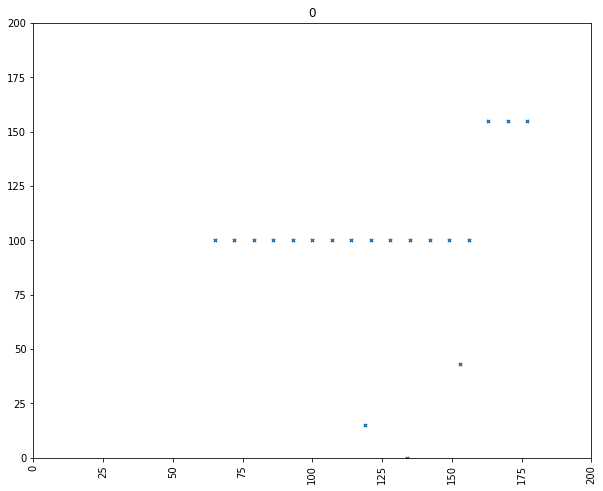

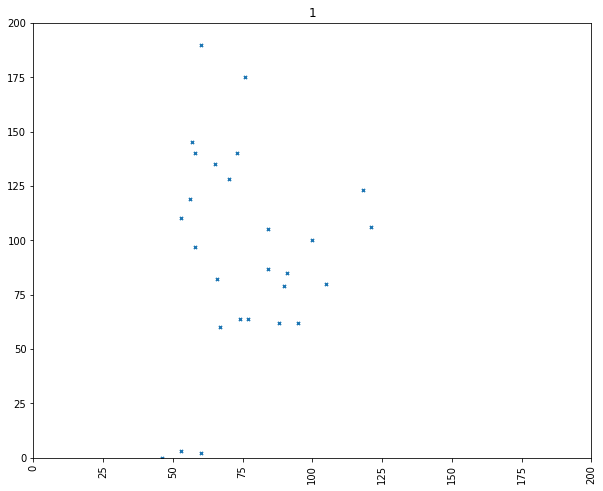

In [441]:
colour_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for i in range(2):
    d_lst, a_lst, g_lst = synthetic_data.make_a_group()
    
    d_arr = np.array(d_lst)
    a_arr = np.array(a_lst)
    g_arr = np.array(g_lst)    
    
    num_trans = len(a_arr)
    idx = np.random.randint(0,num_trans)
    
#     print(num_trans, idx)
    
    pixel_centred_d_arr = find_pixel_centred_d_arr(d_arr, a_arr, idx)
    pixel_centred_a_arr = find_pixel_centred_a_arr(d_arr, a_arr, idx)
    pixel_centred_g_arr = np.repeat(0, len(pixel_centred_a_arr))
    
#     print(len(pixel_centred_d_arr))
#     print(len(pixel_centred_a_arr))
    
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10,8), sharex=True)
    ax1.scatter(pixel_centred_d_arr, pixel_centred_a_arr, s=10, marker='x')
    ax1.set_title(str(i))
    ax1.set_xlim([0,200])
    ax1.set_ylim([0,200])

    
    for ax1 in fig.axes:
        matplotlib.pyplot.sca(ax1)
        plt.xticks(rotation=90)
        #plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    
    plt.show